In [1]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
custom_colors = ['white', "#c45161", "#f2b6c0", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)
color_palette = ['#93003a', '#00429d', '#93c4d2', '#6ebf7c']
matplotlib.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14

from gurobipy import Model, GRB
from gurobipy import quicksum
import gurobipy as gp
import pickle
from tqdm import tqdm
import multiprocessing
import re
import geopandas as gpd
import contextily as ctx
from matplotlib.colors import LogNorm
from shapely.geometry import Point, LineString

### Load data

#### Poi dataset

In [16]:
pois = pd.read_parquet("data/poi.parquet")
pois = gpd.GeoDataFrame(pois, geometry=gpd.points_from_xy(pois.longitude, pois.latitude))

gdf = gpd.read_file('data/tokyo_subdivision_geometry.geojson')
gdf['subdivision_id'] = gdf['binary_subdivision_id'] // 2 // 2 // 2 // 2 // 2
gdf = gdf.dissolve(by='subdivision_id').reset_index()[['subdivision_id', 'geometry']]

merged_poi = gpd.sjoin(gdf, pois, how='right', op='contains')
grouped_by_poi = merged_poi.groupby(['subdivision_id', 'category']).count().reset_index()

activity_seq = {'Home':1, 'Work':2, 'School':3, 'ChildCare':4, 'BuyGoods':5, 'Services':6,
                'EatOut':7, 'Errands':8, 'Recreation':9, 'Exercise':10, 'Visit':11, 'HealthCare':12,
                'Religious':13, 'SomethingElse':14, 'DropOff':15, 'Transportation':16}
poi_density = {}
for i in range(1, 17):
    poi_count = grouped_by_poi[grouped_by_poi['category'].map(activity_seq) == i]['index_left'].to_numpy()
    poi_density[i] = poi_count / poi_count.sum()

In [23]:
# pickle.dump(poi_density, open('input/poi_density.pkl', 'wb'))

### OD flow dataset

In [2]:
od = pd.read_parquet('data/veraset_tokyo_trips_binary_subdivision_id.parquet')
od['start_binary_subdivision_id'] = od['start_binary_subdivision_id'] // 2 // 2 // 2 // 2 // 2
od['end_binary_subdivision_id'] = od['end_binary_subdivision_id'] // 2 // 2 // 2 // 2 // 2
od = od.groupby(['start_binary_subdivision_id', 'end_binary_subdivision_id']).size().reset_index()
od.columns = ['origin', 'destination', 'flow']

In [3]:
inflow = od.groupby('destination')['flow'].sum().reset_index()
outflow = od.groupby('origin')['flow'].sum().reset_index()

### Load activity chains data

In [50]:
df = pd.read_parquet('data/activity.parquet')
df['next_activity'] = df.groupby('agent_id')['act_type'].shift(-1)
df_grouped = df.groupby(['act_type', 'next_activity']).count().reset_index()[['act_type','next_activity','agent_id']]
df_grouped = df_grouped.rename(columns={'agent_id':'count'})
total_num_transitions = df_grouped['count'].sum()
df_grouped_sorted = df_grouped.sort_values('count', ascending=False).head(100).reset_index()

### Specify parameters

In [26]:
out_flow_concentration = {}
in_flow_concentration = {}
for idx, row in df_grouped.iterrows():
    prev_act, nex_act = row['act_type'], int(row['next_activity'])
    out_flow_concentration[idx] = row['count'] * poi_density[prev_act]
    in_flow_concentration[idx] = row['count'] * poi_density[nex_act]
    
N = od['destination'].nunique()
L = df_grouped.shape[0]

expansion_factor = total_num_transitions / inflow['flow'].sum()

od_matrix = np.zeros((N, N))
for idx, row in od.iterrows():
    od_matrix[int(row['origin']), int(row['destination'])] = row['flow'] * expansion_factor

In [142]:
m = Model()
x_ijl = [(i, j, l) for i in range(N) for j in range(N) for l in range(L)]
x_ijl = m.addVars(x_ijl, vtype=GRB.CONTINUOUS, name='x_ijl')

# z_j = [(j) for j in range(N)]
# z_j = m.addVars(z_j, vtype=GRB.CONTINUOUS, name='z_j')

# y_i = [(i) for i in range(N)]
# y_i = m.addVars(y_i, vtype=GRB.CONTINUOUS, name='y_i')

# for j in tqdm(range(N)):
#     m.addConstr(z_j[j] >= quicksum(x_ijl[i, j, l] for i in range(N) for l in range(L))-c[j])
#     m.addConstr(z_j[j] >= -quicksum(x_ijl[i, j, l] for i in range(N) for l in range(L))+c[j])

#     m.addConstr(y_i[j] >= quicksum(x_ijl[j, i, l] for i in range(N) for l in range(L))-d[j])
#     m.addConstr(y_i[j] >= -quicksum(x_ijl[j, i, l] for i in range(N) for l in range(L))+d[j])

z_ij = [(i, j) for i in range(N) for j in range(N)]
z_ij = m.addVars(z_ij, vtype=GRB.CONTINUOUS, name='z_ij')
for i in tqdm(range(N)):
    for j in range(N):
        m.addConstr(z_ij[i, j] >= quicksum(x_ijl[i, j, l] for l in range(L))-od_matrix[i,j])
        m.addConstr(z_ij[i, j] >= -quicksum(x_ijl[i, j, l] for l in range(L))+od_matrix[i,j])


for l in tqdm(range(L)):
    m.addConstr(quicksum(x_ijl[i, j, l] for j in range(N) for i in range(N)) == df_grouped['count'].iloc[l])

for i in tqdm(range(N)):
    for transition in range(len(df_grouped_sorted)):
        transition_index = df_grouped_sorted['index'].iloc[transition]
        m.addConstr(quicksum(x_ijl[i,j,transition_index] for j in range(N)) == out_flow_concentration[transition_index][i])
        m.addConstr(quicksum(x_ijl[j,i,transition_index] for j in range(N)) == in_flow_concentration[transition_index][i])
    
# m.setObjective(quicksum(z_j[j] for j in range(N)) + quicksum(y_i[i] for i in range(N)), GRB.MINIMIZE)
m.setObjective(quicksum(z_ij[i, j] for i in range(N) for j in range(N)), GRB.MINIMIZE)

m.optimize()

100%|██████████| 128/128 [00:03<00:00, 37.65it/s]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)



CPU model: Intel(R) Xeon(R) Gold 6326 CPU @ 2.90GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 32 physical cores, 64 logical processors, using up to 32 threads

Optimize a model with 58564 rows, 3227648 columns and 12943360 nonzeros
Model fingerprint: 0xacf62832
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+07]
Presolve removed 110 rows and 5239 columns (presolve time = 5s) ...
Presolve removed 310 rows and 5239 columns
Presolve time: 8.94s
Presolved: 58254 rows, 3222409 columns, 12890906 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Elapsed ordering time = 5s
Elapsed ordering time = 10s
Elapsed ordering time = 28s
Elapsed ordering time = 30s
Elapsed ordering time = 35s
Ordering time: 35.33s

Barrier statistics:
 AA' NZ     : 1.454e+07
 Factor NZ  : 3.573e+08 (roughly 4.0 GB of memory)
 Factor Ops : 5.538e+

In [143]:
x_ijl_sol = m.getAttr('x', x_ijl)
sol = np.zeros((N, N, L))
for i in range(N):
    for j in range(N):
        for l in range(L):
            sol[i, j, l] = x_ijl_sol[i, j, l]

In [144]:
np.save('input/sol_top_100.npy', sol)

## Visualizations

In [5]:
sol = np.load('input/sol_top_100.npy')

In [81]:
df_grouped_select = df_grouped.sort_values('count', ascending=False).head(9)

In [82]:
activity_seq_inv = {v: k for k, v in activity_seq.items()}

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=3, nrows=3, dpi=50)

vmin = np.log10(10)
vmax = np.log10(sol.max())
# Create individual plots
df_grouped_select = df_grouped_select.reset_index()
for i in range(3):
    for j in range(3):
        index = df_grouped_select['index'][i*3+j]
        im = ax[i, j].imshow(np.log10(sol[:, :, index]), cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
        origin_act = activity_seq_inv[df_grouped_select["act_type"][i*3+j]]
        next_act = activity_seq_inv[df_grouped_select["next_activity"][i*3+j]]
        ax[i, j].set(title=f'{origin_act} to {next_act}')
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.08, pad=0.05)
cbar.set_label('Log10 Flow')  # Label for the colorbar
fig.text(0.5, 0.04, 'Destination', ha='center', fontsize=24)
fig.text(0.04, 0.5, 'Origin', va='center', rotation='vertical', fontsize=24);

In [40]:
import contextily as ctx
from matplotlib.colors import LogNorm
from shapely.geometry import Point, LineString

gdf = gpd.read_file('od_flow/tokyo_subdivision_geometry.geojson')
gdf['subdivision_id'] = gdf['binary_subdivision_id'] // 2 // 2 // 2 // 2 // 2
gdf = gdf.dissolve(by='subdivision_id')


home_to_work_pd = pd.DataFrame(sol[:, :, 3].flatten(), columns=['flow'])
home_to_work_pd['origin'] = np.repeat(np.arange(N), N)
home_to_work_pd['destination'] = np.tile(np.arange(N), N)
home_to_work_pd = pd.merge(home_to_work_pd, gdf, left_on='origin', right_on='subdivision_id')
home_to_work_pd = pd.merge(home_to_work_pd, gdf, left_on='destination', right_on='subdivision_id')
home_to_work_pd['line'] = home_to_work_pd.apply(lambda x: LineString([x['geometry_x'].centroid, x['geometry_y'].centroid]), axis=1)
home_to_work_pd = gpd.GeoDataFrame(home_to_work_pd, geometry='line')

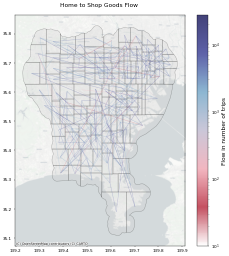

In [226]:
from matplotlib.colors import LinearSegmentedColormap, LogNorm, Normalize
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10), dpi=30)

norm = LogNorm(vmin=10, vmax=sol.max())

# home_to_work_pd['linewidth'] = home_to_work_pd.apply(lambda x: min(x['flow']*0.05, 10*0.5), axis=1)
home_to_work_pd['linewidth'] = home_to_work_pd.apply(lambda x: 1, axis=1)
home_to_work_pd.plot(ax =ax, column='flow', cmap=cmap, legend=True,
           linewidth=home_to_work_pd['linewidth'], alpha=0.4, norm=norm,
           legend_kwds={'label': "Flow in number of trips", 'orientation': "vertical"})
ax.set(title="Home to Shop Goods Flow \n")

gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.3)

ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron, zoom=12)

# ax[1].title.set_position([0, 1.05])

# flow2 = flow_gt.copy()
# # flow2 = flow2[flow2['flow'] > 10]
# norm = LogNorm(vmin=10, vmax=5000)
# flow2.plot(ax=ax[0], column='flow', cmap=cmap, legend=True,
#            linewidth=flow2['flow']*0.005, alpha=0.15, norm=norm,
#            legend_kwds={'label': "Flow in number of trips", 'orientation': "vertical"})
# ctx.add_basemap(ax[0], crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)
# ax[0].set(title="A) SERPM OD Flow \n")
# # ax[0].title.set_position([0, 1.05])

# flow3 = flow_vae.copy()
# # flow3 = flow3[flow3['flow'] > 5] 
# norm = LogNorm(vmin=10, vmax=200)
# flow3['linewidth'] = flow3.apply(lambda x: min(x['flow']*0.005, 10*0.5), axis=1)
# flow3.plot(ax =ax[2], column='flow', cmap=cmap, legend=True,
#            linewidth=flow3['linewidth'], alpha=0.15, norm=norm,
#            legend_kwds={'label': "Flow in number of trips", 'orientation': "vertical"})
# ctx.add_basemap(ax[2], crs='EPSG:4326', source=ctx.providers.OpenStreetMap.DE, zoom=12)
# ax[2].set(title="C) TrajSynVAE OD Flow \n")

# dot_lat, dot_lon = 25.7492, -80.2635
# dot = gpd.GeoDataFrame(geometry=[Point(dot_lon, dot_lat)], crs='EPSG:4326')
# dot.plot(ax=ax[0], color='red', markersize=100, label='City of Coral Gables', zorder=5)
# dot.plot(ax=ax[1], color='red', markersize=100, label='City of Coral Gables', zorder=5)
# dot.plot(ax=ax[2], color='red', markersize=100, label='City of Coral Gables', zorder=5)
# ax[0].legend()
# ax[1].legend()
# ax[2].legend()

In [25]:


vmin = np.log10(10)
vmax = np.log10(od_matrix).max()


# fig, ax = plt.subplots(ncols=2, figsize=(10, 4), dpi=50)
# cbar = plt.colorbar(ax[0].imshow(np.log10(od_matrix), cmap=cmap, interpolation='nearest'))
# cbar.set_label('Log10 Flow')
# cbar = plt.colorbar(ax[1].imshow(np.log10(sol.sum(axis=2)), cmap=cmap, interpolation='nearest'))
# ax[0].set(xlabel='Origin Zone', ylabel='Destination Zone', title='OD Flow from LBS Data');
# ax[1].set(xlabel='Origin Zone', ylabel='Destination Zone', title='OD Flow from Model');
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), dpi=50)

# Use the same color scale for both plots
im1 = ax[0].imshow(np.log10(od_matrix), cmap='viridis', vmin=vmin, vmax=vmax, interpolation='nearest')
im2 = ax[1].imshow(np.log10(sol.sum(axis=2)), cmap='viridis', vmin=vmin, vmax=vmax, interpolation='nearest')

# Add a single shared colorbar
fig.colorbar(im1, ax=ax[1], location='right', label='Log10 Flow')

# Set labels and titles
ax[0].set(xlabel='Origin Zone', ylabel='Destination Zone', title='OD Flow from LBS Data')
ax[1].set(xlabel='Origin Zone', ylabel='Destination Zone', title='OD Flow from Model')

# Show plot
plt.tight_layout()
plt.show()

NameError: name 'od_matrix' is not defined

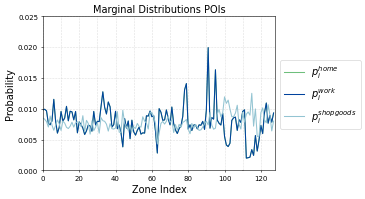

In [24]:
marginal_home = sol[:,:,0].sum(axis=1)
marginal_home = marginal_home / marginal_home.sum()

marginal_work = sol[:,:,0].sum(axis=0)
marginal_work = marginal_work / marginal_work.sum()

marginal_buy_goods = sol[:,:,56].sum(axis=1)
marginal_buy_goods = marginal_buy_goods / marginal_buy_goods.sum()

fig, ax = plt.subplots(figsize=(6, 4), dpi=50)
ax.plot(marginal_home, color=color_palette[3], label=r'$p_{i}^{home}$')
ax.plot(marginal_work, color=color_palette[1], label=r'$p_{i}^{work}$')
ax.plot(marginal_buy_goods, color=color_palette[2], label=r'$p_{i}^{shop goods}$')
minorLocator = MultipleLocator(10)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(True, alpha=0.4, linestyle='--', which='both')
ax.set(ylim=(0, 0.025), xlim=(0, 128), xlabel='Zone Index', ylabel='Probability', title='Marginal Distributions POIs')
ax.legend(bbox_to_anchor=(1,0.75), loc='upper left');


### Matching Algorithm

In [6]:
sol = np.load('sol_top_100.npy')

In [5]:
transition_to_index = {}
for idx, row in df_grouped.iterrows():
    transition_to_index[(row['act_type'], row['next_activity'])] = idx

In [101]:
class Sampler:
    def __init__(self, sol, df, df_grouped, poi_density):
        self.sol = sol
        self.df = df
        self.df_grouped = df_grouped
        self.users = df['agent_id'].unique()[:1000]
        self.poi_density = poi_density


    def match(self):
        all_matched = {}
        for user in tqdm(self.users):
            home, work = self._pick_home_work()
            user_df = self.df[self.df['agent_id'] == user].reset_index(drop=True)
            if user_df.loc[0]['act_type'] == 1:
                locations = [home]
            elif user_df.loc[0]['act_type'] == 2:
                locations = [work]
            else:
                locations = [self._init_sample(user_df.loc[0]['act_type'])]
            
            prev_loc = locations[0]

            for idx, row in user_df.iterrows():
                if pd.isna(row['next_activity']):
                    break
                if row['next_activity'] == 1:
                    next_loc = home
                    t_idx = transition_to_index[(row['act_type'], row['next_activity'])]
                    # self.sol[prev_loc, next_loc, t_idx] -= 1
                elif row['next_activity'] == 2:
                    next_loc = work
                    transition_index = self.df_grouped[(self.df_grouped['act_type'] == row['act_type']) & (self.df_grouped['next_activity'] == 2)].index[0]
                    # self.sol[prev_loc, next_loc, transition_index] -= 1

                else:
                    next_loc = self._sample(row['act_type'], row['next_activity'], prev_loc)
                
                locations.append(next_loc)
                prev_loc = next_loc
            all_matched[user] = locations
        self.all_matched = all_matched

    def parse_result(self):
        res = []
        for user, locs in self.all_matched.items():
            for loc in locs:
                res.append({'agent_id': user, 'location': loc})
        self.res = pd.DataFrame(res)
        return self.res

    def _init_sample(self, act_type):
        den = self.poi_density[act_type]
        return np.random.choice(np.arange(len(den)), p=den)
        
    
    def _pick_home_work(self):
        home = np.random.choice(np.arange(len(self.poi_density[1])), p=self.poi_density[1])
        work_prob = self.sol[home,:,transition_to_index[(1, 2)]]
        work_prob = abs(work_prob+0.0000001) / abs(work_prob+0.0000001).sum()
        work = np.random.choice(np.arange(len(work_prob)), p=work_prob)
        return home, work

    def _sample(self, prev_act, next_act, origin):
        transition_index = transition_to_index[(prev_act, next_act)]
        prob = self.sol[origin, :, transition_index]
        prob = abs(prob+0.0000001) / abs(prob+0.0000001).sum()
        destination = np.random.choice(np.arange(len(prob)), p=prob)

        # self.sol[origin, destination, transition_index] -= 1
        return destination

In [19]:
test = Sampler(sol, df[df['agent_id'] == 200].reset_index(drop=True), poi_density)
test_df = test.match()

In [102]:
a = Sampler(sol, df, df_grouped, poi_density, transition_to_index)
a.match()
res = a.parse_result()

100%|██████████| 1000/1000 [01:56<00:00,  8.55it/s]


In [124]:
raw_df = pd.read_parquet('activity.parquet')
merged = pd.concat([raw_df[raw_df['agent_id'].isin(raw_df['agent_id'].unique()[:1000])], res['location']], axis=1)
geo = gdf.reset_index()
geo['centroid'] = geo['geometry'].centroid

In [125]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance


distance = {}
for i in range(geo.shape[0]):
    for j in range(geo.shape[0]):
        distance[i, j] = haversine_distance(geo.loc[i, 'centroid'].y, geo.loc[i, 'centroid'].x, geo.loc[j, 'centroid'].y, geo.loc[j, 'centroid'].x)
        distance[j, i] = distance[i,j]

In [126]:
merged['next_loc'] = merged.groupby('agent_id')['location'].shift(-1)
merged = merged.dropna()
merged['distance'] = merged.apply(lambda x: distance[x['location'], x['next_loc']], axis=1)


In [127]:
df_rg = pd.merge(merged, geo, left_on='location', right_on='subdivision_id', how='left')
def geographic_center(points):
    x_total = y_total = z_total = 0.0
    for point in points:
        lon = point.x
        lat = point.y
        lat_rad = math.radians(lat)
        lon_rad = math.radians(lon)
        
        x = math.cos(lat_rad) * math.cos(lon_rad)
        y = math.cos(lat_rad) * math.sin(lon_rad)
        z = math.sin(lat_rad)
        
        x_total += x
        y_total += y
        z_total += z

    num_points = len(points)
    x_avg = x_total / num_points
    y_avg = y_total / num_points
    z_avg = z_total / num_points

    lon_center = math.atan2(y_avg, x_avg)
    hyp = math.sqrt(x_avg * x_avg + y_avg * y_avg)
    lat_center = math.atan2(z_avg, hyp)

    return (math.degrees(lon_center), math.degrees(lat_center))

com_agent = []
for agent in tqdm(df_rg['agent_id'].unique()):
    agent_df = df_rg[df_rg['agent_id'] == agent]
    com_agent.append({'agent_id': agent, 'location': geographic_center(agent_df['centroid'].tolist())})

100%|██████████| 1000/1000 [00:03<00:00, 332.35it/s]


In [128]:
rg_df = pd.DataFrame(com_agent)
rg_df.rename(columns={'location': 'com'}, inplace=True)
df_rg_final = pd.merge(df_rg, rg_df, on='agent_id', how='left')
df_rg_final['distance_from_com'] = df_rg_final.apply(lambda x: haversine_distance(x['com'][1], x['com'][0], x['centroid'].y, x['centroid'].x), axis=1)
df_rg_final['squared'] = df_rg_final['distance_from_com']**2
rg = np.array(df_rg_final.groupby('agent_id')['squared'].mean()**0.5)

In [129]:
df2 = pd.read_parquet('v2/veraset_tokyo_trips_binary_subdivision_id.parquet')
df2['distance'] = df2.apply(lambda x: haversine_distance(x['start_latitude'], x['start_longitude'], x['end_latitude'], x['end_longitude']), axis=1)

In [130]:
sort_by_count = df2.groupby('caid').count().sort_values('trip_start_datetime', ascending=False).reset_index()
selected_users = sort_by_count[sort_by_count['trip_start_datetime'] > 30]['caid'][:1000]
df2_filtered = df2[df2['caid'].isin(selected_users)]

In [131]:
com_agent_lbs = []
for agent in tqdm(df2_filtered['caid'].unique()):
    agent_df = df2[df2['caid'] == agent]
    list_of_points = []
    for idx, row in agent_df.iterrows():
        list_of_points.append(Point(row['start_longitude'], row['start_latitude']))
    com_agent_lbs.append({'agent': agent, 'location': geographic_center(list_of_points)})

100%|██████████| 1000/1000 [01:34<00:00, 10.56it/s]


In [132]:
rg_lbs = pd.DataFrame(com_agent_lbs)
rg_lbs.rename(columns={'location': 'com', 'agent':'caid'}, inplace=True)
rg_lbs = pd.merge(df2_filtered, rg_lbs, on='caid', how='left')
rg_lbs['distance_from_com'] = rg_lbs.apply(lambda x: haversine_distance(x['com'][1], x['com'][0], x['start_latitude'], x['start_longitude']), axis=1)
rg_lbs['squared'] = rg_lbs['distance_from_com']**2
rg_lbs = np.array(rg_lbs.groupby('caid')['squared'].mean()**0.5)

In [133]:
hist, bins = np.histogram(merged['distance'].to_numpy(), bins=np.arange(2,80))
trip_dist = hist/hist.sum()

hist, bins = np.histogram(df2['distance'].to_numpy(), bins=np.arange(2,80))
trip_dist_lbs = hist/hist.sum()

hist, bins = np.histogram(rg, bins=np.arange(2, 50))
rg_dist = hist/hist.sum()

hist, bins = np.histogram(rg_lbs, bins=np.arange(2, 50))
rg_dist_lbs = hist/hist.sum()



[Text(0.5, 1.0, 'rg')]

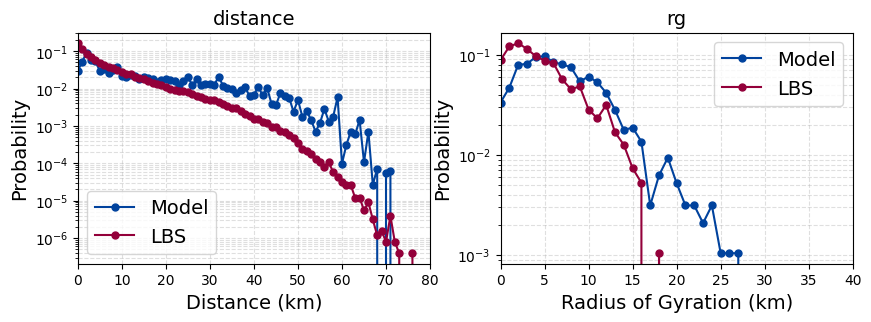

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=100)
ax[0].plot(trip_dist, color=color_palette[1], marker='o', markersize=5, label='Model')
ax[0].plot(trip_dist_lbs, color=color_palette[0], marker='o', markersize=5, label='LBS')
ax[0].set_yscale('log')

ax[1].plot(rg_dist, color=color_palette[1], marker='o', markersize=5, label='Model')
ax[1].plot(rg_dist_lbs, color=color_palette[0], marker='o', markersize=5, label='LBS')
ax[1].set_yscale('log')

ax[0].set(xlim=(0, 80), xlabel='Distance (km)', ylabel='Probability', title='Distance Distribution')
ax[1].set(xlim=(0, 40), xlabel='Radius of Gyration (km)', ylabel='Probability', title='Radius of Gyration Distribution')


# ax[0].set(xlabel='$N$', xticks=np.arange(0,12,2), xticklabels=np.arange(1,13,2),
#           xlim=(0,12))
# ax[1].set(xlabel='$t$', xticks=np.arange(0,25,8), xticklabels=['12am', '8am', '4pm', '12am'], xlim=(0,24))
# ax[2].set(xlabel='$\Delta t$', xticks=[0,6,12,18,24], xticklabels=['0', '6', '12', '18', '24'], xlim=(0,24))

# fig.text(0.03, 0.5, 'Probability', ha='center', va='center', rotation='vertical', fontsize=32)
# plt.subplots_adjust(wspace=0.35)
# plt.legend(bbox_to_anchor=(-2.3,-0.35), loc='upper left', ncol=2, fontsize=24);

for i in range(2):
    minorLocator = MultipleLocator(10)
    ax[i].xaxis.set_minor_locator(minorLocator)
    ax[i].grid(True, alpha=0.4, linestyle='--', which='both')
    ax[i].legend()

ax[0].set(title='distance')
ax[1].set(title='rg')

# ax[0].text(-0.06, 1.2, "A)", transform=ax[0].transAxes, fontsize=24, verticalalignment='top')
# ax[1].text(-0.06, 1.2, "B)", transform=ax[1].transAxes, fontsize=24, verticalalignment='top')
# ax[2].text(-0.06, 1.2, "C)", transform=ax[2].transAxes, fontsize=24, verticalalignment='top');




In [136]:
df

,household_id,agent_id,event_id,act_type,person_id,event_scope,day_index,start_time,end_time,day_of_week,next_activity
0,0,0,27,1,0,FAMILY,0,0,34,0,2.0
1,0,0,29,2,0,FAMILY,0,35,64,0,4.0
2,0,0,32,4,0,FAMILY,0,64,71,0,1.0
3,0,0,34,1,0,FAMILY,0,72,96,0,1.0
4,0,0,35,1,0,FAMILY,1,0,34,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...
113031817,244905,541764,64,9,1,FAMILY,9,40,70,2,1.0
113031818,244905,541764,66,1,1,FAMILY,9,73,96,2,1.0
113031819,244905,541764,47,1,1,FAMILY,10,0,40,3,7.0
113031820,244905,541764,67,7,1,FAMILY,10,40,72,3,1.0


In [40]:
import os
files = os.listdir('output/')
df = pd.DataFrame()
for file in tqdm(files):
    if file.endswith('.csv'):
        df = pd.concat([df, pd.read_csv('output/' + file)])

100%|██████████| 50/50 [02:26<00:00,  2.93s/it]


In [41]:
df = df.sort_values('agent_id')
df.to_parquet('tokyo_matched_0212.parquet')

## Archive

In [ ]:
# Type	Detail
# 1	 Regular home activities (chores, sleep) 
# 1	 Work from home (paid) 
# 2	 Work 
# 2	 Work-related meeting / trip 
# 2	 Volunteer activities (not paid) 
# 3	 Attend school as a student
# 4	 Attend child care 
# 4	 Attend adult care
# 5	 Buy goods (groceries, clothes, appliances, gas) 
# 6	 Buy services (dry cleaners, banking, service a car 
# 7	 Buy meals (go out for a meal, snack, carry-out) 
# 8	 Other general errands (post office, library)
# 9	 Recreational activities (visit parks, movies, bars
# 10	 Exercise (go for a jog, walk, walk the dog, go to the gym
# 11	 Visit friends or relatives
# 12	 Health care visit (medical, dental, therapy) 
# 13	 Religious or other community activities
# 14	 Something else 
# 15	 Drop off /pick up someone
# 16 (optional)       Transportation

# activity_type_poi = {1: [1, ['multi_family', 'single_family']], 2: [1, ['commercial']], 
#                      3: [2, ['education']], 4: [2, ['healthcare']], 5: [2, ['store']],
#                      6: [1, ['retail/service']], 7: [1, ['retail/service']], 8: [1, ['retail/service']],
#                      9: [2, ['park', 'indoor_recreation', 'theater', 'night_club']], 10: [2, ['park', 'sports']],
#                      11: [1, ['multi_family', 'single_family']], 12: [2, ['healthcare']], 13: [2, ['religious']],
#                      14: 'any', 15: 'any'}

# poi_density = {}
# for i in range(1, 16):
#     if activity_type_poi[i] == 'any':
#         poi_i = pois.groupby('binary_subdivision_id').size().reset_index()
#         poi_i.columns = ['binary_subdivision_id', 'poi_density']
#         poi_density[i] = np.array(poi_i['poi_density'] / poi_i['poi_density'].sum())
#     elif activity_type_poi[i][0] == 1:
#         poi_i = pois[pois['ps__category_level1'].isin(activity_type_poi[i][1])].groupby('binary_subdivision_id').size().reset_index()
#         poi_i.columns = ['binary_subdivision_id', 'poi_density']
#         poi_density[i] = np.array(poi_i['poi_density'] / poi_i['poi_density'].sum())
#     elif activity_type_poi[i][0] == 2:
#         poi_i = pois[pois['ps__category_level2'].isin(activity_type_poi[i][1])].groupby('binary_subdivision_id').size().reset_index()
#         poi_i.columns = ['binary_subdivision_id', 'poi_density']
#         poi_density[i] = np.array(poi_i['poi_density'] / poi_i['poi_density'].sum())